In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from logger import logger
import os
import cv2
import pydot
import tensorflow as tf
#-------------------------------------------------
import keras.backend as K
from keras.applications import inception_v3, inception_resnet_v2
from keras import callbacks as Kcallbacks
from keras.utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal,glorot_uniform
from keras.regularizers import l2
from keras.layers import Dense, Conv2D, Input, Activation, ZeroPadding2D, BatchNormalization,\
    Flatten, MaxPooling2D, Dropout, concatenate, AveragePooling2D
#-------------------------------------------------------------------------
from tensorflow import losses as tflosses
%matplotlib inline
np.random.seed(40)
seed = 40

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
train = np.load('./data/train/train_dataset.npy')
labels = np.load('./data/train/labels.npy')
print (train.shape, labels.shape, sep=' - ')

(1604, 75, 75, 4) - (1604, 1)


In [3]:
def prepare_test_data() :
    test_dataset = np.load('./data/test/test_dataset.npy')
    test_ids = np.load('./data/test/ids.npy')
    print (test_dataset.shape, test_ids.shape, sep=' - ')
    return test_dataset, test_ids

In [4]:
def get_more_images(imgs, epoches):
    
    more_images = []
    rotated_imgs = []
    for e in range(epoches) :
        for i in range(0,imgs.shape[0]):
            a=imgs[i,:,:,0]
            b=imgs[i,:,:,1]
            c=imgs[i,:,:,2]
            d=imgs[i,:,:,3]
            
            #angle = np.random.randint(0,360)
            scale = np.random.random(1) * .6 + 1
            M = cv2.getRotationMatrix2D( (a.shape[0]/2,a.shape[1]/2),0 , scale)

            a1 = cv2.warpAffine(a, M, a.shape)
            b1 = cv2.warpAffine(b, M, a.shape)
            c1 = cv2.warpAffine(c, M, a.shape)
            d1 = cv2.warpAffine(d, M, a.shape)
            
            rotated_imgs.append(np.dstack((a1,b1,c1,d1)))
            
            
    r = np.array(rotated_imgs)
       
    more_images = np.concatenate((imgs,r))
    
    return more_images

#--------
e = 3
#---------
if e == 0 :
    train_ext = train.copy()
    labels_ext = labels.copy()
else :
    train_ext = get_more_images(train, e)
    labels_ext = np.concatenate([labels for i in range(e+1)])
print (train_ext.shape, labels_ext.shape, sep=' - ')
del train, labels

(6416, 75, 75, 4) - (6416, 1)


In [5]:
# getting validation set
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train_ext, labels_ext,
                                                                            test_size=.0000001,shuffle=True)


print (train_dataset.shape, train_labels.shape, sep=' - ')
print (valid_dataset.shape, valid_labels.shape, sep=' - ')

del  train_ext, labels_ext

(6415, 75, 75, 4) - (6415, 1)
(1, 75, 75, 4) - (1, 1)


------------------------

 ** An iceberg


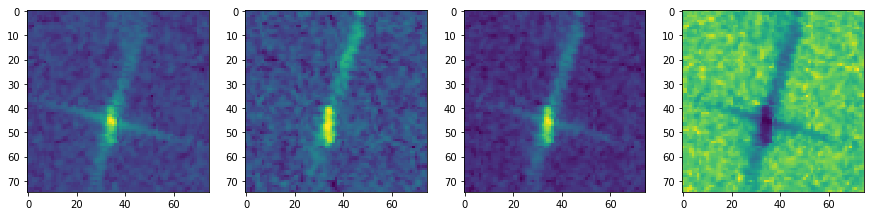

In [6]:
plt.rcParams["figure.figsize"] = [15,15]
index = np.random.randint(0, train_dataset.shape[0])
f, axarr = plt.subplots(1,train_dataset.shape[3])
for i in range(train_dataset.shape[3]):
    _ = axarr[i].imshow(train_dataset[index,:,:,i])

print (" ** A ship" if train_labels[index,0] == 1 else " ** An iceberg")

In [ ]:
train_dataset = train_dataset[:,:,:,[2,3]]

In [7]:
def block_2layers(X, block_id, filters):
    X = Dropout(.2, name='block%s_dropout'%block_id)(X)
    X = Conv2D(filters, 3, padding='same', name='block%s_conv1' % block_id)(X)
    X = BatchNormalization(axis=3, name='block%s_BN1' % block_id)(X)
    X = Activation('relu', name='block%s_layer1' % block_id)(X)
    #--------------------------------------
    X = Conv2D(filters, 3, padding='same', name='block%s_conv2'%block_id)(X)
    X = BatchNormalization(axis=3, name='block%s_BN2'%block_id)(X)
    X = Activation('relu', name='block%s_layer2'%block_id)(X)
    #-------------------------------
    X = MaxPooling2D(2, 2, name='block%s_booled'%block_id)(X)
    return X
#----------------------------------------------------
def block_3layers(X, block_id, filters):
    X = Dropout(.2, name='block%s_dropout'%block_id)(X)
    X = Conv2D(filters, 3, padding='same', name='block%s_conv1' % block_id)(X)
    X = BatchNormalization(axis=3, name='block%s_BN1' % block_id)(X)
    X = Activation('relu', name='block%s_layer1' % block_id)(X)
    #--------------------------------------
    X = Conv2D(filters, 3, padding='same', name='block%s_conv2'%block_id)(X)
    X = BatchNormalization(axis=3, name='block%s_BN2'%block_id)(X)
    X = Activation('relu', name='block%s_layer2'%block_id)(X)
    #--------------------------------------
    X = Conv2D(filters, 3, padding='same', name='block%s_conv3'%block_id)(X)
    X = BatchNormalization(axis=3, name='block%s_BN3'%block_id)(X)
    X = Activation('relu', name='block%s_layer3'%block_id)(X)
    #-------------------------------
    X = MaxPooling2D(2, 2, name='block%s_booled'%block_id)(X)
    return X
#----------------------------------------------------
def get_VGG_model(input_shape):
    X_input = Input(input_shape, name='input')
    # Block 1
    X = block_2layers(X_input, '1', 64)
    #Block 2
    X = block_2layers(X, '2', 128)
    X = block_2layers(X, '3', 128)
    #X = block_2layers(X, '4', 128)
    X = block_2layers(X, '5', 64)
    #Block 3
    #X = block_3layers(X, '3', 256)
    #Block 4
    #X = block_3layers(X, '4', 512)
    #Block 5
    #X = block_3layers(X, '5', 512)
    # TOP
    X = Flatten(name='Flatten')(X)
    #FC1
    X = Dropout(.2, name='FC1_drop')(X)
    X = Dense(256, activation='relu', name='FC1',
             kernel_initializer=glorot_uniform(seed),kernel_regularizer=l2())(X)
    X = BatchNormalization(name='FC1_BN')(X)
    #FC2
    X = Dropout(.2, name='FC2_drop')(X)
    X = Dense(256, activation='relu', name='FC2'
              ,kernel_initializer=glorot_uniform(seed),kernel_regularizer=l2())(X)
    X = BatchNormalization(name='FC2_BN')(X)
    #OUTPUT
    X = Dropout(.2, name='FC3_drop')(X)
    X = Dense(1, activation='sigmoid', name='output',
             kernel_initializer=glorot_uniform(seed),kernel_regularizer=l2())(X)
    #----------------
    model = Model(inputs=X_input, outputs=X)
    return model
#--------------------------------------------
model = get_VGG_model([75,75,4])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 75, 75, 4)         0         
_________________________________________________________________
block1_dropout (Dropout)     (None, 75, 75, 4)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        2368      
_________________________________________________________________
block1_BN1 (BatchNormalizati (None, 75, 75, 64)        256       
_________________________________________________________________
block1_layer1 (Activation)   (None, 75, 75, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_BN2 (BatchNormalizati (None, 75, 75, 64)        256       
__________

In [ ]:
#model.compile(Adam(lr=.001), loss='hinge',metrics=[tflosses.log_loss])

In [8]:
model.compile(Adam(lr=.001), loss='binary_crossentropy',metrics=[])

In [9]:
callbacks = [ 
    Kcallbacks.EarlyStopping(patience=20, verbose=1, mode='min'),
    Kcallbacks.History(),
    Kcallbacks.CSVLogger('./tmp/keras/checkpoints/5/logger2.log', append=True),
    Kcallbacks.ReduceLROnPlateau(factor=.1, patience=10, verbose=1),
    Kcallbacks.ModelCheckpoint('./tmp/keras/checkpoints/5/ckpt2-{val_loss:.4f}-{epoch:02d}.hdf5',
                               verbose=1, save_best_only=1, mode='min')
] 

model.fit(x=train_dataset, y=train_labels, batch_size=32, epochs=100, shuffle=True, verbose=1, 
          validation_split=.2, callbacks=callbacks)

Train on 5132 samples, validate on 1283 samples
Epoch 1/100
5132/5132 [==============================] - 1405s 274ms/step - loss: 4.6890 - val_loss: 3.0586
Epoch 2/100
5132/5132 [==============================] - 1210s 236ms/step - loss: 1.7904 - val_loss: 1.2645
Epoch 3/100
5132/5132 [==============================] - 1345s 262ms/step - loss: 0.8648 - val_loss: 0.7778
Epoch 4/100
5132/5132 [==============================] - 1404s 274ms/step - loss: 0.5393 - val_loss: 0.9708
Epoch 5/100
5132/5132 [==============================] - 1387s 270ms/step - loss: 0.4025 - val_loss: 0.3590
Epoch 6/100
5132/5132 [==============================] - 1483s 289ms/step - loss: 0.3295 - val_loss: 0.5664
Epoch 7/100
5132/5132 [==============================] - 1367s 266ms/step - loss: 0.2909 - val_loss: 0.6157
Epoch 8/100
5132/5132 [==============================] - 1174s 229ms/step - loss: 0.2895 - val_loss: 0.3305
Epoch 9/100
5132/5132 [==============================] - 1169s 228ms/step - loss: 0.2661

5132/5132 [==============================] - 1164s 227ms/step - loss: 0.0966 - val_loss: 0.1621
Epoch 35/100
5132/5132 [==============================] - 1165s 227ms/step - loss: 0.0773 - val_loss: 0.3658
Epoch 36/100
5132/5132 [==============================] - 1172s 228ms/step - loss: 0.0970 - val_loss: 0.0877
Epoch 37/100
5132/5132 [==============================] - 1173s 229ms/step - loss: 0.0943 - val_loss: 0.1058
Epoch 38/100
5132/5132 [==============================] - 1170s 228ms/step - loss: 0.0975 - val_loss: 0.1292
Epoch 39/100
5132/5132 [==============================] - 1169s 228ms/step - loss: 0.0795 - val_loss: 0.2459
Epoch 40/100
5132/5132 [==============================] - 1171s 228ms/step - loss: 0.0920 - val_loss: 0.2630
Epoch 41/100
5132/5132 [==============================] - 1171s 228ms/step - loss: 0.0893 - val_loss: 0.1109
Epoch 42/100
5132/5132 [==============================] - 1170s 228ms/step - loss: 0.1031 - val_loss: 0.1170
Epoch 43/100
5132/5132 [========

KeyboardInterrupt: 

In [ ]:
model.evaluate(train_dataset, train_labels)

In [ ]:
best_model.evaluate(train_dataset[2500:2700], train_labels[2500:2700])

In [10]:
def predict_test_dataset(model, subid):
    test_data, test_ids = prepare_test_data()
    #test_data = test_data[:,:,:,[2,3]]
    test_preds = model.predict(test_data, batch_size=200, verbose=1)
    sub_df = pd.DataFrame({'id':test_ids, 'is_iceberg':test_preds.reshape((-1))})
    sub_df.to_csv('./tmp/keras/checkpoints/5/submission-{}'.format(subid), index=False)

In [11]:
predict_test_dataset(model, '.09')

(8424, 75, 75, 4) - (8424,)
8424/8424 [==============================] - 741s 88ms/step


In [ ]:
best_model = load_model('./tmp/keras/checkpoints/1/ckpt-0.2062-34.hdf5',
                        custom_objects={'log_loss':tflosses.log_loss})

In [ ]:
plot_model(best_model, to_file='./model.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

------------------------------------

In [ ]:
X_input = Input([75,75,4], name='X_input')
model = inception_v3.InceptionV3(input_tensor=X_input, pooling='max', classes=1, weights=None)

In [ ]:
inc_model.summary()